In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa, librosa.display
import wave
import IPython.display as ipd
import os
import tensorflow as tf
print(tf.__version__)
import re
from tqdm import tqdm 
import plotly.express as px
import plotly.graph_objects as go
import sklearn
import datetime
import pandas as apd
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
%matplotlib inline

2.0.0


In [77]:
tf.random.set_seed(999)
np.random.seed(999)

In [96]:
dataset_prefix='STFT_MAG'
## librosa config
NUM_CLASSES=5
SAMPLE_RATE=16000
N_MFCC=40
WINDOW_LENGTH=512
OVERLAP=round(0.25 * WINDOW_LENGTH)
WINDOW = scipy.signal.hamming(WINDOW_LENGTH, sym=False)

In [97]:
basepath = '../data/raw/TCD-VOIP'

In [98]:
dataframe = pd.read_excel(os.path.join(basepath, 'TCD VOIP - Test Set Conditions and MOS Results.xlsx'), sheet_name='Subjective Test Scores')
dataframe['ref']=dataframe['Filename'].str.replace('C_', 'ref/R_',1)
# shuffle the data frame
dataframe = dataframe.sample(frac=1).reset_index(drop=True)

noise_type = []
for index, row in dataframe.iterrows():
    filename = row['Filename']
    n_type = re.findall('.*?_([A-Z]+)_.*', filename)[0]
    noise_type.append(n_type)
dataframe['noise_type'] = noise_type

dataframe.head()

Filename  ConditionID  sample MOS  listener  # ->  1  2  3  4  5  \
0  C_15_ECHO_FG.wav           15    2.041667             NaN  2  3  2  2  1   
1  C_04_CLIP_FG.wav            4    3.291667             NaN  3  2  2  3  5   
2  C_03_CLIP_FA.wav            3    3.791667             NaN  3  3  4  5  5   
3  C_06_CHOP_FA.wav            6    4.458333             NaN  4  3  4  5  5   
4  C_01_ECHO_MK.wav            1    4.875000             NaN  5  4  5  5  5   

   6  ...  17  18  19  20  21  22  23  24                   ref  noise_type  
0  2  ...   2   2   1   2   2   3   1   2  ref/R_15_ECHO_FG.wav        ECHO  
1  3  ...   3   3   4   3   3   4   3   2  ref/R_04_CLIP_FG.wav        CLIP  
2  3  ...   4   3   5   3   2   4   4   4  ref/R_03_CLIP_FA.wav        CLIP  
3  5  ...   3   4   5   5   4   5   4   4  ref/R_06_CHOP_FA.wav        CHOP  
4  5  ...   4   5   4   5   5   5   5   5  ref/R_01_ECHO_MK.wav        ECHO  

[5 rows x 30 columns]

In [99]:
print(dataframe.shape)

(384, 30)


In [100]:
# add the noise type as a dataframe column
stats = pd.DataFrame({"min":dataframe.groupby(['noise_type']).min()['sample MOS'],
"max": dataframe.groupby(['noise_type']).max()['sample MOS'],
"mean": dataframe.groupby(['noise_type']).mean()['sample MOS'],
"count": dataframe.groupby(['noise_type']).count()['sample MOS']})
stats['probs'] = stats['count'].values / np.sum(stats['count'])
stats.head()

min       max      mean  count     probs
noise_type                                               
CHOP        1.250000  4.875000  3.299479     96  0.250000
CLIP        1.166667  4.708333  3.292411     56  0.145833
COMPSPKR    1.541667  4.666667  3.314732     56  0.145833
ECHO        1.125000  4.875000  3.018229     80  0.208333
NOISE       1.375000  4.833333  3.212674     96  0.250000

In [101]:
# Here we use a column with categorical data
fig = px.histogram(dataframe['noise_type'], x="noise_type")

fig.update_layout(
    title_text='TCD-VoIP degradations', # title of plot
    xaxis_title_text='Types of degradation', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.1, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

In [102]:
fig = px.histogram(dataframe['sample MOS'], x="sample MOS", nbins=30, 
                   color_discrete_sequence=['indianred'])
fig.update_layout(
    title_text='TCD-VoIP subjective scores', # title of plot
    xaxis_title_text='Sample MOS', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.01, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

## Chop

In [103]:
audio_path = '../data/raw/TCD-VOIP/Audio/chop/C_01_CHOP_FA.wav'
x , sr = librosa.load(audio_path)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [104]:
ipd.Audio(audio_path)

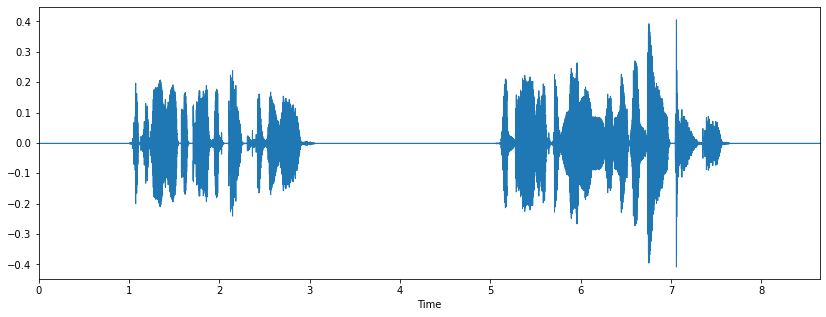

In [56]:
#display waveform
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

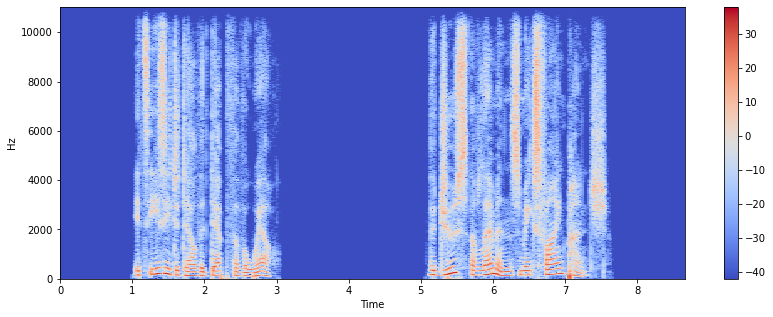

In [57]:
#display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

## Clip

In [58]:
audio_path = '../data/raw/TCD-VOIP/Audio/clip/C_01_CLIP_FA.wav'
x , sr = librosa.load(audio_path)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [59]:
ipd.Audio(audio_path)

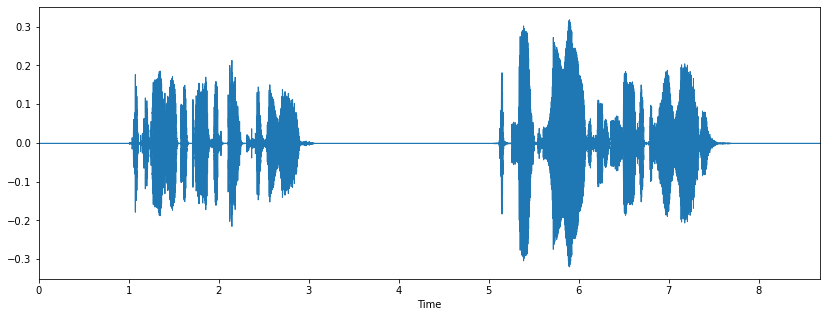

In [60]:
#display waveform
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

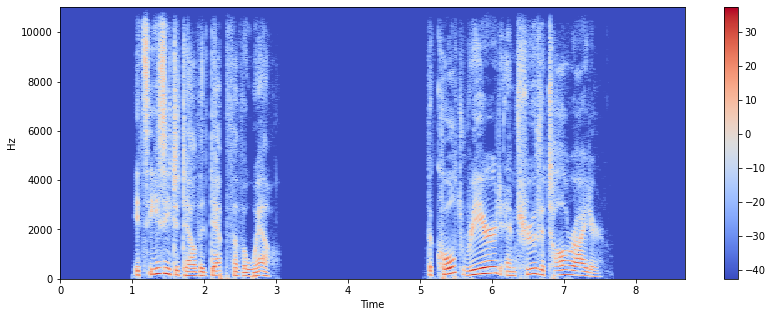

In [61]:
#display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

In [62]:
audio_path = '../data/raw/TCD-VOIP/Audio/compspkr/C_01_COMPSPKR_FA.wav'
x , sr = librosa.load(audio_path)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [63]:
ipd.Audio(audio_path)

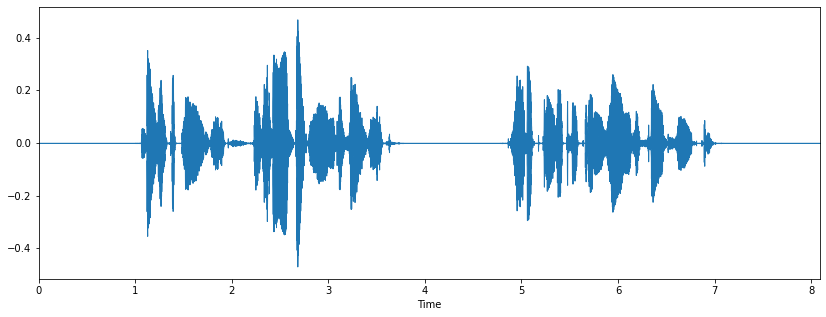

In [64]:
#display waveform
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

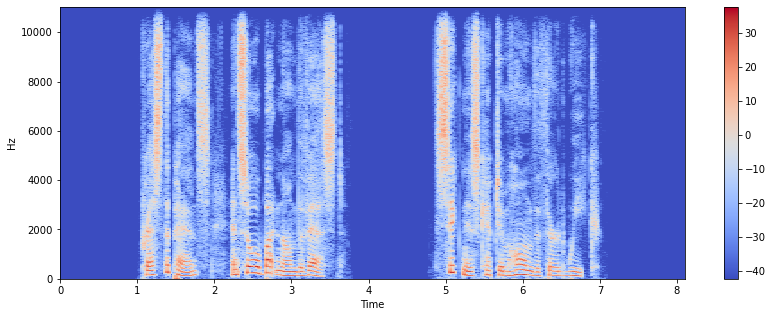

In [65]:
#display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

In [105]:
count = np.bincount(dataframe['sample MOS'])
print(count)
n_clean_files = round(np.mean(count))
print(n_clean_files)

[  0  63  85 133 103]
77


In [106]:
class FeatureExtractor:
    def __init__(self, windowLength, overlap, sample_rate):
        self.ffT_length = windowLength
        self.window_length = windowLength
        self.overlap = overlap
        self.sample_rate = sample_rate
        self.window = scipy.signal.hamming(self.window_length, sym=False)

    def get_stft_spectrogram(self, audio, spectrogram=False):
        S = librosa.stft(audio, n_fft=self.ffT_length, win_length=self.window_length, hop_length=self.overlap,
                            window=self.window, center=True)
        S = np.abs(S)
        if spectrogram:
            return np.square(S)
        else:
            return S

    def get_constant_q_spectrogram(self, audio, n_bins=84):
        # Compute the constant-Q transform of an audio signal.
        C = librosa.core.cqt(audio, sr=self.sample_rate, hop_length=self.overlap, fmin=None,
                                n_bins=n_bins, bins_per_octave=12, tuning=0.0,
                                filter_scale=1, norm=1, sparsity=0.01, window='hann', scale=True,
                                pad_mode='reflect',
                                res_type=None)
        return np.abs(C)

    def get_mfcc_features(self, audio, n_mfcc=40):
        S = self.get_mel_spectrogram(audio)
        return librosa.feature.mfcc(S=librosa.power_to_db(S), sr=self.sample_rate, n_mfcc=n_mfcc)

    def get_mel_spectrogram(self, audio):
        D = self.get_stft_spectrogram(audio, spectrogram=True)
        S = librosa.feature.melspectrogram(S=D, sr=self.sample_rate, power=2.0, pad_mode='reflect',
                                              n_fft=self.ffT_length, hop_length=self.overlap, center=True)
        return S

In [107]:
extractor = FeatureExtractor(WINDOW_LENGTH, OVERLAP, SAMPLE_RATE)

In [108]:
def get_feature_extractor_func(feature_type):
    print("Feature type:", feature_type)
    feature_map = {'STFT_SPEC': lambda audio: extractor.get_stft_spectrogram(audio, spectrogram=True),
                   'STFT_MAG' : lambda audio: extractor.get_stft_spectrogram(audio, spectrogram=False),
                   'MFCC': lambda audio: extractor.get_mfcc_features(audio),
                   'MEL_SPEC': lambda audio: extractor.get_mel_spectrogram(audio),
                   'CQT': lambda audio: extractor.get_constant_q_spectrogram(audio)}
    return feature_map.get(feature_type)

In [109]:
get_feature_vector = get_feature_extractor_func(dataset_prefix)

Feature type: STFT_MAG


In [110]:
get_feature_vector(x).shape[1]

1490

In [111]:
max_feature_len = []
def extract_features(audio, sr, max_pad_len):
   
    try:
        features = get_feature_vector(audio)
#         print(features.shape[1])
        pad_width = max_pad_len - features.shape[1]
#         print(pad_width)
        max_feature_len.append(features.shape[1])
        
        if pad_width < 0:
            print("Cropping original features depth of:", features.shape[1], 'to:', max_pad_len)
            features = features[:,:max_pad_len]
        else:
            features = np.pad(features, pad_width=((0, 0), (0, pad_width)), mode='wrap')
            
    except Exception as e:
        print("Error encountered.", e)
        return None 
     
    return features

def _remove_silent_frames(audio):
    trimed_audio = []
    indices = librosa.effects.split(audio, top_db=60)

    for index in indices:
        trimed_audio.extend(audio[index[0]: index[1]])
    return np.array(trimed_audio)

In [112]:
import math

def _audio_random_crop(audio, duration, sample_rate):
    # Compute the duration (in seconds) of an audio time series
    audio_duration_secs = librosa.core.get_duration(audio, sample_rate)

    ## duration: length of the cropped audio in seconds
    if duration >= audio_duration_secs:
        print("Passed duration greater than audio duration of: ", audio_duration_secs)
        audio = np.pad(audio, pad_width=((0, 0), (0, audio.size)), mode='wrap')
        return audio

    audio_duration_ms = math.floor(audio_duration_secs * sample_rate)
    duration_ms = math.floor(duration * sample_rate)
    idx = np.random.randint(0, audio_duration_ms - duration_ms)
    return audio[idx: idx + duration_ms]

In [113]:
NOISE_CLASS_MAP = {'NOISE': 0, 'CHOP': 1, 'COMPSPKR': 2, 'ECHO': 3, 'CLIP': 4}

def next_record(dataframe):
    for index, row in tqdm(dataframe.iterrows()):
        filename = row['Filename']
        noise_type = row['noise_type']

        audio_path = os.path.join(basepath, 'Audio', noise_type.lower(), filename)
        audio, sr = librosa.load(audio_path, sr=SAMPLE_RATE)
        audio =  _remove_silent_frames(audio)
        # using mfccs and random cropping the audio produces high overfitting
        # audio = _audio_random_crop(audio, 1.6, SAMPLE_RATE)
        
        # for mfcc, crop to 311
        # for CQT, STFT and MEL, crop to 1241
        
        feature_vector = extract_features(audio, sr, 1241)
        class_label = NOISE_CLASS_MAP[noise_type]
        sample_MOS = row['sample MOS']
        yield feature_vector, class_label, sample_MOS, filename

In [114]:
features = []
class_labels = []
sample_MOS = []
filenames = []

for i in range(1):
    data_generator = next_record(dataframe)
    for input_, target_, MOS, filename in data_generator:
        #print(input_.shape)
        features.append(input_)
        class_labels.append(target_)
        sample_MOS.append(MOS)
        filenames.append(filename)
    print("End of epoch:", i)

384it [02:00,  3.19it/s]

End of epoch: 0


In [115]:
filenames = np.asarray(filenames)
features = np.asarray(features)
class_labels = np.asarray(class_labels)
sample_MOS = np.asarray(sample_MOS)
features = np.expand_dims(features, axis=3)

In [116]:
# # normalize the score to the range [0-1]
# sample_MOS = (sample_MOS - 1) / 4
# print(np.min(sample_MOS), np.max(sample_MOS))
# print(sample_MOS[:20])

In [117]:
print("Feature shape:", features.shape)
print("Feature range (Min/Max):", np.min(max_feature_len), np.max(max_feature_len))

Feature shape: (384, 257, 1241, 1)
Feature range (Min/Max): 397 1241


In [118]:
print("Training data shape")
print(features.shape)
print(class_labels.shape)
print(sample_MOS.shape)

Training data shape
(384, 257, 1241, 1)
(384,)
(384,)


1.6493274e-11


C:\Users\HP\.conda\envs\capstone\lib\site-packages\librosa\display.py:1155: UserWarning:

Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?

C:\Users\HP\.conda\envs\capstone\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning:

The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



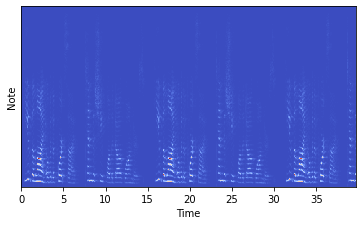

In [119]:
for C in features:
    print(np.min(C))
    plt.imshow(np.squeeze(C))
    librosa.display.specshow(np.squeeze(C), sr=SAMPLE_RATE, x_axis='time', y_axis='cqt_note', cmap='coolwarm')
    plt.show()
    break

In [120]:
# train test split
test_size_percentage = 0.15
test_size = int(test_size_percentage * features.shape[0])

In [121]:
X_train = {'filenames': filenames[:-test_size], 
           'features': features[:-test_size], 
           'class_labels': class_labels[:-test_size], 
           'sample_MOS': sample_MOS[:-test_size]}

X_test = { 'filenames': filenames[-test_size:], 
           'features': features[-test_size:], 
           'class_labels': class_labels[-test_size:], 
           'sample_MOS': sample_MOS[-test_size:]}

In [122]:
features

array([[[[1.06591200e-02],
         [1.83632877e-02],
         [1.74004883e-02],
         ...,
         [2.50395406e-02],
         [9.51840449e-03],
         [3.37811708e-02]],

        [[4.65860264e-03],
         [1.59128476e-02],
         [1.89806111e-02],
         ...,
         [1.57913025e-02],
         [2.63462011e-02],
         [5.36854081e-02]],

        [[4.63191979e-03],
         [1.00705056e-02],
         [8.21974780e-03],
         ...,
         [3.55526619e-02],
         [2.59129778e-02],
         [4.21763025e-02]],

        ...,

        [[2.74665144e-05],
         [2.41950988e-06],
         [3.59061087e-05],
         ...,
         [4.59312956e-04],
         [9.29357135e-04],
         [1.56865735e-03]],

        [[2.91727865e-05],
         [7.86218698e-06],
         [2.27465534e-05],
         ...,
         [7.23030171e-05],
         [7.33553141e-04],
         [1.61972514e-03]],

        [[2.92586628e-05],
         [5.60196804e-06],
         [2.45195934e-05],
         ...,
 

In [123]:
# # save the numpy data
np.save('../data/processed/TDC_VoIP_train_'+ dataset_prefix , X_train)
np.save('../data/processed/TDC_VoIP_test_' + dataset_prefix , X_test)